In [1]:
import pandas as pd
import numpy as np
import scipy 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from random import choices


from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

import os
import gc
import pickle

In [3]:
# sns.set_style('darkgrid')
# plt.style.use('fivethirtyeight')

In [2]:
os.chdir("../../")
root_path = os.getcwd()

In [3]:
raw_file_path = os.path.join(root_path, "Bigcon2020_raw_file")
csv_file_path = os.path.join(root_path, "BigCon_2020/csv_files")
pickle_file_path = os.path.join(root_path, "BigCon_2020/pickle_files")

In [4]:
raw_file_folders = os.listdir(raw_file_path)

In [5]:
plt.style.use('ggplot')

In [6]:
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = "Malgun Gothic"

### Read Excel File

In [7]:
file_name = '04_혁신아이디어분야_유통데이터(GS리테일)_데이터정의서 및 문제 데이터.xlsx'

In [10]:
file_path = os.path.join(raw_file_path, raw_file_folders[3], file_name)

In [11]:
def_table = pd.read_excel(file_path, header = [5], usecols=[2,4,5,6])

In [21]:
sheet_name = ['동별매출지수', '카테고리별 매출비중', '종합테이블(TB_DD_STR_PURCH_CLS)']
headers = [[3], [0], [0]]

In [22]:
df_list = []

for sheet,header in zip(sheet_name,headers):
    df_list.append(pd.read_excel(file_path, sheet_name=sheet, header=header))

In [24]:
by_dong, by_category, total = df_list

In [8]:
# by_category = pd.read_excel("./04_혁신아이디어분야_유통데이터(GS리테일)_데이터정의서 및 문제 데이터.xlsx", sheet_name='카테고리별 매출비중')
# by_dong = pd.read_excel("./04_혁신아이디어분야_유통데이터(GS리테일)_데이터정의서 및 문제 데이터.xlsx", sheet_name='동별매출지수', header=[3])
# total = pd.read_excel("./04_혁신아이디어분야_유통데이터(GS리테일)_데이터정의서 및 문제 데이터.xlsx", sheet_name='종합테이블(TB_DD_STR_PURCH_CLS)')

#### 지역 이름<->코드 변환  

In [18]:
# name_to_code = pd.read_excel("./04_혁신아이디어분야_유통데이터(GS리테일)_데이터정의서 및 문제 데이터.xlsx", sheet_name='참고)구_행정동코드', header=[1], usecols=[1,2,3,4,5,6])

In [28]:
"""
si_name_to_code = name_to_code.iloc[:,:2].drop_duplicates(keep='last').set_index('시명').to_dict()
gu_name_to_code = name_to_code.iloc[:,2:4].drop_duplicates(keep='last').set_index('구명').to_dict()
dong_name_to_code = name_to_code.iloc[:,4:].drop_duplicates(keep='last').set_index('행정동명').to_dict()

name_to_code_dict = {}

name_to_code_dict.update(si_name_to_code)
name_to_code_dict.update(gu_name_to_code)
name_to_code_dict.update(dong_name_to_code)
"""

"\nsi_name_to_code = name_to_code.iloc[:,:2].drop_duplicates(keep='last').set_index('시명').to_dict()\ngu_name_to_code = name_to_code.iloc[:,2:4].drop_duplicates(keep='last').set_index('구명').to_dict()\ndong_name_to_code = name_to_code.iloc[:,4:].drop_duplicates(keep='last').set_index('행정동명').to_dict()\n\nname_to_code_dict = {}\n\nname_to_code_dict.update(si_name_to_code)\nname_to_code_dict.update(gu_name_to_code)\nname_to_code_dict.update(dong_name_to_code)\n"

In [29]:
# 지역명<->지역코드 변환용 pickle file생성
"""
with open("convert_name_to_code.pickle", 'wb') as f:
    pickle.dump(name_to_code_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
"""    

'\nwith open("convert_name_to_code.pickle", \'wb\') as f:\n    pickle.dump(name_to_code_dict, f, protocol=pickle.HIGHEST_PROTOCOL)\n'

In [35]:
file_name = 'convert_name_to_code.pickle'
file_path = os.path.join(pickle_file_path, file_name)

In [37]:
with open(file_path, 'rb') as f:
    convert_name_to_code_dict =pickle.load(f)

### 동별+일자별 매출지수 

* 매출기준동 및 기준일 : **2019.04.11**, **서울 중구 신당5동**

In [39]:
by_dong.head()

,PVN,BOR,ADMD,20190201,20190202,20190203,20190204,20190205,20190206,20190207,...,20200522,20200523,20200524,20200525,20200526,20200527,20200528,20200529,20200530,20200531
0,전체,NaN,NaN,1.198007,1.017985,0.963684,0.918759,1.028130,0.900022,1.062491,...,1.080985,1.020417,0.885803,1.021254,1.067526,1.063149,1.076086,1.137684,1.045754,0.928725
1,서울특별시,NaN,NaN,1.188696,1.004386,0.953775,0.899579,1.036262,0.892765,1.079589,...,1.162798,1.078928,0.930147,1.098651,1.143194,1.147769,1.169708,1.226083,1.110484,0.978101
2,서울특별시,중구,NaN,1.379749,1.037523,1.013265,0.898529,1.003199,0.892831,1.264520,...,1.230307,0.998263,0.777919,1.186941,1.259630,1.243106,1.289460,1.295647,1.002761,0.849583
3,서울특별시,중구,소공동,1.668360,1.115390,1.211998,1.033635,1.112612,1.054682,1.834032,...,1.484447,0.819555,0.608719,1.334733,1.475264,1.499739,1.566971,1.491554,0.785321,0.680223
4,서울특별시,중구,회현동,1.216539,1.231600,1.216814,1.264384,1.245211,1.186977,1.185489,...,1.123279,0.813363,0.665930,1.198933,1.253730,1.236836,1.179716,1.232473,0.793768,0.773963


In [40]:
# 결측값 위치 확인
by_dong.isnull().sum()[by_dong.isnull().sum() != 0]

BOR     3
ADMD    7
dtype: int64

In [41]:
# 행정동 이름이 중복되는 경우는 없음
by_dong.loc[~by_dong.ADMD.isnull(), 'ADMD'].shape[0] == by_dong.loc[~by_dong.ADMD.isnull(), 'ADMD'].nunique()

True

In [42]:
# 결측치 채워넣기
by_dong = by_dong.fillna('전체')

In [43]:
region = pd.DataFrame(by_dong.iloc[:,:3].apply(lambda x : '_'.join(set(tuple(x))), axis=1), columns = ['region'])

In [44]:
region

,region
0,전체
1,전체_서울특별시
2,중구_전체_서울특별시
3,중구_소공동_서울특별시
4,중구_회현동_서울특별시
...,...
62,대구광역시_범물1동_수성구
63,대구광역시_범물2동_수성구
64,대구광역시_고산1동_수성구
65,대구광역시_고산2동_수성구


In [45]:
#지역명을 하나의 변수에 저장
by_dong = pd.concat([region, by_dong], axis=1)

In [14]:
# by_dong.drop('region', axis=1, inplace=True)

In [46]:
by_dong.head()

,region,PVN,BOR,ADMD,20190201,20190202,20190203,20190204,20190205,20190206,...,20200522,20200523,20200524,20200525,20200526,20200527,20200528,20200529,20200530,20200531
0,전체,전체,전체,전체,1.198007,1.017985,0.963684,0.918759,1.028130,0.900022,...,1.080985,1.020417,0.885803,1.021254,1.067526,1.063149,1.076086,1.137684,1.045754,0.928725
1,전체_서울특별시,서울특별시,전체,전체,1.188696,1.004386,0.953775,0.899579,1.036262,0.892765,...,1.162798,1.078928,0.930147,1.098651,1.143194,1.147769,1.169708,1.226083,1.110484,0.978101
2,중구_전체_서울특별시,서울특별시,중구,전체,1.379749,1.037523,1.013265,0.898529,1.003199,0.892831,...,1.230307,0.998263,0.777919,1.186941,1.259630,1.243106,1.289460,1.295647,1.002761,0.849583
3,중구_소공동_서울특별시,서울특별시,중구,소공동,1.668360,1.115390,1.211998,1.033635,1.112612,1.054682,...,1.484447,0.819555,0.608719,1.334733,1.475264,1.499739,1.566971,1.491554,0.785321,0.680223
4,중구_회현동_서울특별시,서울특별시,중구,회현동,1.216539,1.231600,1.216814,1.264384,1.245211,1.186977,...,1.123279,0.813363,0.665930,1.198933,1.253730,1.236836,1.179716,1.232473,0.793768,0.773963


In [47]:
# 데이터프레임 처리하기 쉽게 하기 위해 세부지역명 변수들 삭제

drop_cols = ['PVN', 'BOR', 'ADMD']
by_dong.drop(drop_cols, axis=1, inplace=True)

In [48]:
# 2019년, 2020년 나누어 저장

year_2019 = [date for date in by_dong.columns[1:] if date[:4] == '2019'] 
year_2020 = [date for date in by_dong.columns[1:] if date[:4] == '2020'] 

days = year_2019 + year_2020

In [49]:
by_dong = by_dong.set_index('region').T

In [50]:
by_dong.index = pd.to_datetime(days)

In [52]:
by_dong.head()

region,전체,전체_서울특별시,중구_전체_서울특별시,중구_소공동_서울특별시,중구_회현동_서울특별시,중구_명동_서울특별시,중구_필동_서울특별시,중구_장충동_서울특별시,중구_광희동_서울특별시,중구_을지로동_서울특별시,...,황금2동_대구광역시_수성구,대구광역시_중동_수성구,두산동_대구광역시_수성구,대구광역시_지산1동_수성구,대구광역시_지산2동_수성구,대구광역시_범물1동_수성구,대구광역시_범물2동_수성구,대구광역시_고산1동_수성구,대구광역시_고산2동_수성구,대구광역시_고산3동_수성구
2019-02-01,1.198007,1.188696,1.379749,1.668360,1.216539,1.745169,1.318691,0.683687,1.333576,1.941382,...,0.841288,0.793327,0.724868,0.766050,0.723051,0.755404,1.049858,1.064336,1.076418,0.856071
2019-02-02,1.017985,1.004386,1.037523,1.115390,1.231600,0.877985,0.846679,0.634688,1.218764,1.652997,...,0.900834,0.781239,1.092902,0.798443,0.764009,0.918263,0.858762,0.940026,1.172479,0.895912
2019-02-03,0.963684,0.953775,1.013265,1.211998,1.216814,1.042494,0.804650,0.628240,1.215231,1.862871,...,0.909217,0.717100,0.933239,0.954136,0.691206,0.820164,0.885710,0.943638,1.153766,0.924304
2019-02-04,0.918759,0.899579,0.898529,1.033635,1.264384,0.901114,0.713423,0.548837,1.082775,1.406014,...,0.881589,0.618027,0.937714,0.858541,0.838233,1.043473,0.976652,0.954553,1.556855,0.901465
2019-02-05,1.028130,1.036262,1.003199,1.112612,1.245211,1.034272,0.803480,0.574801,0.992551,1.487089,...,0.932320,0.701007,1.013661,0.776843,0.815406,1.065493,1.270511,0.989785,1.658221,0.984660


In [53]:
 # choices(by_dong.columns, k=5)

In [124]:
"""
tmp_df = by_dong.loc[:,  choices(by_dong.columns, k=5)[0]].iloc[:len(year_2019)]
tmp_df2 = by_dong.loc[:,  choices(by_dong.columns, k=5)[0:1]].iloc[len(year_2019):]

fig, ax = plt.subplots(figsize=(14,4))

sns.lineplot(x=tmp_df.reset_index(drop=True).index, y=tmp_df.values.reshape(120,), color = 'red', label = '2019', ax=ax, linewidth=1)

g = ax.twiny()
g = sns.lineplot(x=tmp_df2.reset_index(drop=True).index, y=tmp_df2.values.reshape(121,), color = 'blue', label = '2020', ax=ax, linewidth=1)

ax.set_xticklabels([f'{day[4:6]}-{day[6:]}' for day in days][::10])
ax.set_title(f'{choices(by_dong.columns, k=5)[0]}')
"""

"\ntmp_df = by_dong.loc[:,  choices(by_dong.columns, k=5)[0]].iloc[:len(year_2019)]\ntmp_df2 = by_dong.loc[:,  choices(by_dong.columns, k=5)[0:1]].iloc[len(year_2019):]\n\nfig, ax = plt.subplots(figsize=(14,4))\n\nsns.lineplot(x=tmp_df.reset_index(drop=True).index, y=tmp_df.values.reshape(120,), color = 'red', label = '2019', ax=ax, linewidth=1)\n\ng = ax.twiny()\ng = sns.lineplot(x=tmp_df2.reset_index(drop=True).index, y=tmp_df2.values.reshape(121,), color = 'blue', label = '2020', ax=ax, linewidth=1)\n\nax.set_xticklabels([f'{day[4:6]}-{day[6:]}' for day in days][::10])\nax.set_title(f'{choices(by_dong.columns, k=5)[0]}')\n"

In [54]:
def sales_flow_random_dong(df_dong ,n_dong = 10):
    global year_2019
    global year_2020
    global days
    
    random_dong = choices(df_dong.columns, k=n_dong)
    
    for dong in random_dong:
        
        tmp_df = df_dong.loc[:,dong].iloc[:len(year_2019)]
        tmp_df2 = df_dong.loc[:,dong].iloc[len(year_2019):]
        
        fig, ax = plt.subplots(figsize=(14,4))
        
        sns.lineplot(x=tmp_df.reset_index(drop=True).index, y=tmp_df.values, color='red', label = '2019', ax=ax, linewidth=1)
        
        g = ax.twiny()
        g = sns.lineplot(x=tmp_df2.reset_index(drop=True).index, y=tmp_df2.values, color='blue', label = '2020', ax=ax, linewidth=1)

        ax.set_xticklabels([f'{day[4:6]}-{day[6:]}' for day in days][0::15])
        ax.set_title(f'{dong} 매출흐름')
        
        plt.show()
        
    gc.collect()

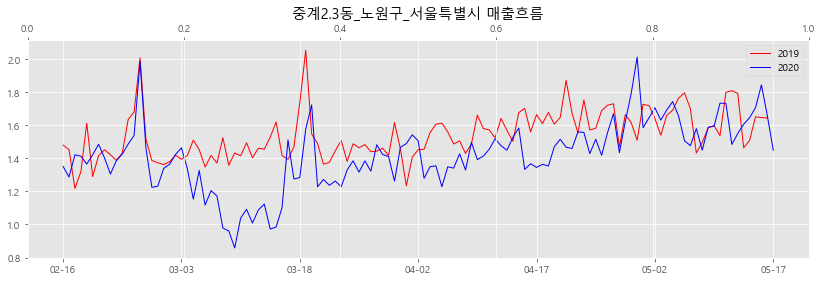

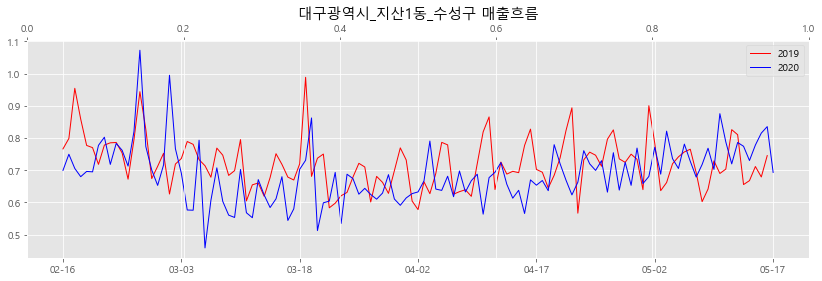

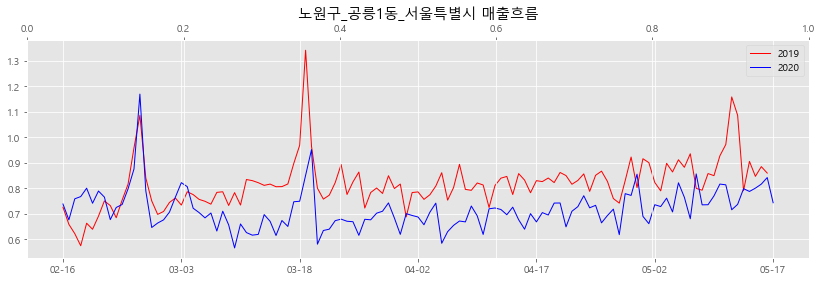

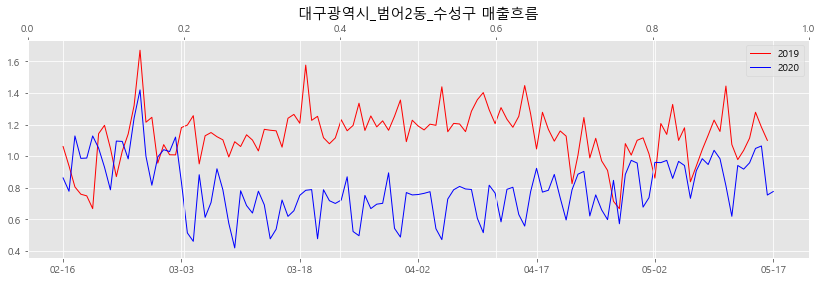

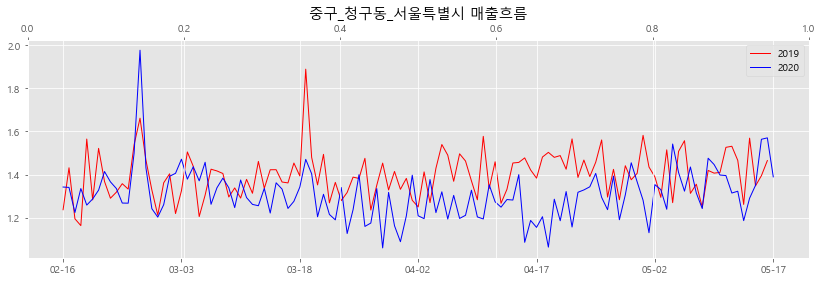

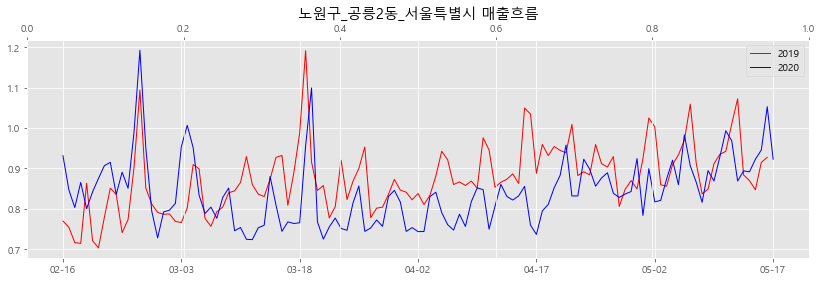

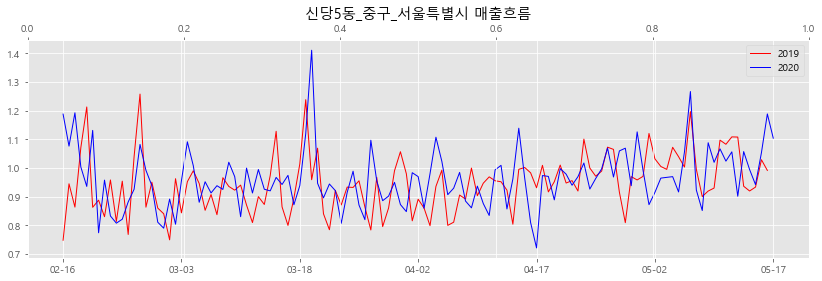

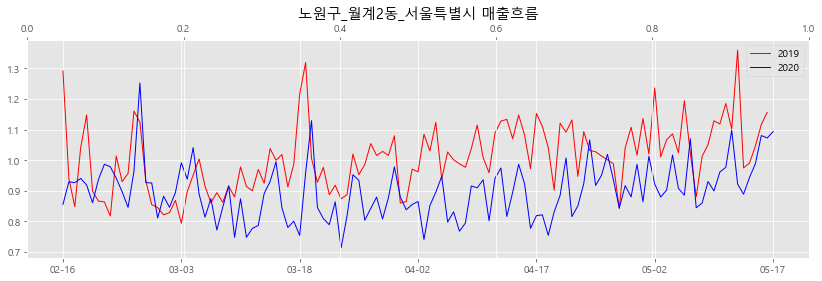

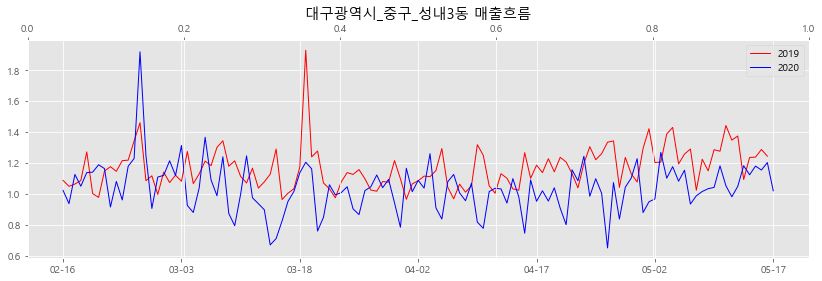

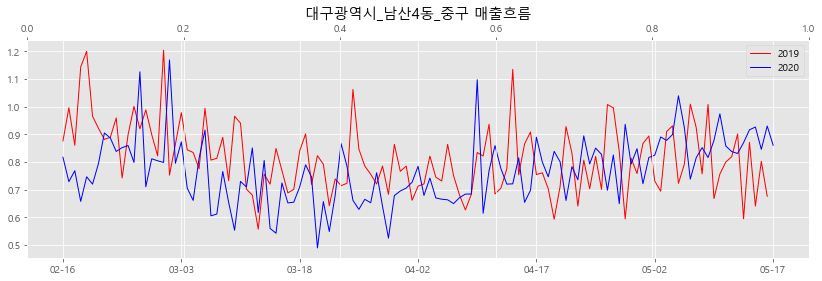

In [55]:
sales_flow_random_dong(by_dong)

#### 매출액 변화

In [56]:
import copy

In [57]:
tmp_df = copy.deepcopy(by_dong)

In [58]:
tmp_df.T.apply(lambda x : tmp_df.T.columns[np.argmin(list(x))], axis=1).reset_index(name='최대매출감소일').head()

,region,최대매출감소일
0,전체,2020-03-01
1,전체_서울특별시,2020-03-01
2,중구_전체_서울특별시,2020-03-15
3,중구_소공동_서울특별시,2020-04-12
4,중구_회현동_서울특별시,2020-05-02


In [59]:
daily_fluctuation = (tmp_df - tmp_df.shift().fillna(0)) / tmp_df.shift().fillna(1)

In [60]:
daily_fluctuation.head()

region,전체,전체_서울특별시,중구_전체_서울특별시,중구_소공동_서울특별시,중구_회현동_서울특별시,중구_명동_서울특별시,중구_필동_서울특별시,중구_장충동_서울특별시,중구_광희동_서울특별시,중구_을지로동_서울특별시,...,황금2동_대구광역시_수성구,대구광역시_중동_수성구,두산동_대구광역시_수성구,대구광역시_지산1동_수성구,대구광역시_지산2동_수성구,대구광역시_범물1동_수성구,대구광역시_범물2동_수성구,대구광역시_고산1동_수성구,대구광역시_고산2동_수성구,대구광역시_고산3동_수성구
2019-02-01,1.198007,1.188696,1.379749,1.668360,1.216539,1.745169,1.318691,0.683687,1.333576,1.941382,...,0.841288,0.793327,0.724868,0.766050,0.723051,0.755404,1.049858,1.064336,1.076418,0.856071
2019-02-02,-0.150267,-0.155052,-0.248035,-0.331445,0.012380,-0.496906,-0.357940,-0.071669,-0.086093,-0.148546,...,0.070780,-0.015237,0.507726,0.042286,0.056646,0.215592,-0.182021,-0.116795,0.089241,0.046538
2019-02-03,-0.053342,-0.050390,-0.023380,0.086613,-0.012005,0.187371,-0.049640,-0.010160,-0.002899,0.126965,...,0.009305,-0.082099,-0.146091,0.194995,-0.095291,-0.106831,0.031381,0.003842,-0.015960,0.031692
2019-02-04,-0.046618,-0.056823,-0.113233,-0.147164,0.039093,-0.135617,-0.113375,-0.126390,-0.108997,-0.245243,...,-0.030386,-0.138158,0.004795,-0.100190,0.212711,0.272273,0.102676,0.011567,0.349369,-0.024710
2019-02-05,0.119043,0.151941,0.116490,0.076408,-0.015163,0.147771,0.126233,0.047307,-0.083327,0.057663,...,0.057544,0.134267,0.080992,-0.095159,-0.027232,0.021103,0.300885,0.036910,0.065109,0.092290


In [61]:
daily_fluctuation.T.apply(lambda x : daily_fluctuation.T.columns[np.argmin(list(x))], axis=1).reset_index(name='최대매출비율감소일').head()

,region,최대매출비율감소일
0,전체,2020-03-15
1,전체_서울특별시,2020-02-15
2,중구_전체_서울특별시,2020-02-15
3,중구_소공동_서울특별시,2020-03-14
4,중구_회현동_서울특별시,2020-05-09


In [62]:
sales_diff = tmp_df.T.apply(lambda x : tmp_df.T.columns[np.argmin(list(x))], axis=1).reset_index(name='최대매출감소일').merge(
    daily_fluctuation.T.apply(lambda x : daily_fluctuation.T.columns[np.argmin(list(x))], axis=1).reset_index(name='최대매출비율감소일')
)

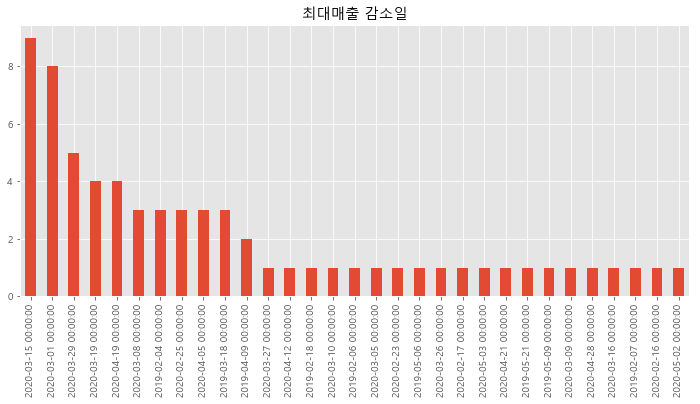

In [63]:
plt.title("최대매출 감소일")
sales_diff.최대매출감소일.value_counts().plot(kind = 'bar', figsize=(12,5))

Text(0.5, 1.0, '최대매출비율 감소일')

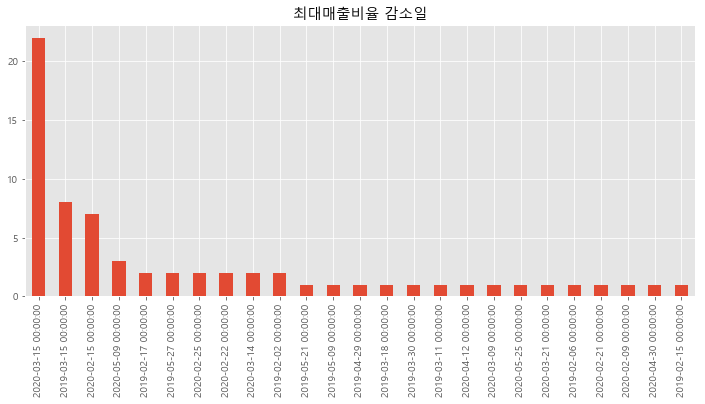

In [64]:
sales_diff.최대매출비율감소일.value_counts().plot(kind = 'bar', figsize=(12,5))
plt.title("최대매출비율 감소일")

* 3월 15일 => 이전날인 3월 14일(화이트데이)이 다른날에 비해 매출액이 높은 것으로 추정할 수 있음
* 매출비중이 줄기 전날이 기념일인 경우가 많은 듯 (화이트데이, 어버이날, 발렌타인데이 등 ) 

In [66]:
by_dong

region,전체,전체_서울특별시,중구_전체_서울특별시,중구_소공동_서울특별시,중구_회현동_서울특별시,중구_명동_서울특별시,중구_필동_서울특별시,중구_장충동_서울특별시,중구_광희동_서울특별시,중구_을지로동_서울특별시,...,황금2동_대구광역시_수성구,대구광역시_중동_수성구,두산동_대구광역시_수성구,대구광역시_지산1동_수성구,대구광역시_지산2동_수성구,대구광역시_범물1동_수성구,대구광역시_범물2동_수성구,대구광역시_고산1동_수성구,대구광역시_고산2동_수성구,대구광역시_고산3동_수성구
2019-02-01,1.198007,1.188696,1.379749,1.668360,1.216539,1.745169,1.318691,0.683687,1.333576,1.941382,...,0.841288,0.793327,0.724868,0.766050,0.723051,0.755404,1.049858,1.064336,1.076418,0.856071
2019-02-02,1.017985,1.004386,1.037523,1.115390,1.231600,0.877985,0.846679,0.634688,1.218764,1.652997,...,0.900834,0.781239,1.092902,0.798443,0.764009,0.918263,0.858762,0.940026,1.172479,0.895912
2019-02-03,0.963684,0.953775,1.013265,1.211998,1.216814,1.042494,0.804650,0.628240,1.215231,1.862871,...,0.909217,0.717100,0.933239,0.954136,0.691206,0.820164,0.885710,0.943638,1.153766,0.924304
2019-02-04,0.918759,0.899579,0.898529,1.033635,1.264384,0.901114,0.713423,0.548837,1.082775,1.406014,...,0.881589,0.618027,0.937714,0.858541,0.838233,1.043473,0.976652,0.954553,1.556855,0.901465
2019-02-05,1.028130,1.036262,1.003199,1.112612,1.245211,1.034272,0.803480,0.574801,0.992551,1.487089,...,0.932320,0.701007,1.013661,0.776843,0.815406,1.065493,1.270511,0.989785,1.658221,0.984660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-27,1.063149,1.147769,1.243106,1.499739,1.236836,1.317534,1.214138,0.719813,0.921369,1.078466,...,0.855166,0.865073,1.004069,0.729972,0.670760,0.897434,0.756833,0.745286,1.189024,0.653439
2020-05-28,1.076086,1.169708,1.289460,1.566971,1.179716,1.385399,1.312843,0.765797,0.986600,1.087520,...,0.848524,0.821186,1.039728,0.777944,0.682781,0.850776,0.706694,0.733123,1.180665,0.700569
2020-05-29,1.137684,1.226083,1.295647,1.491554,1.232473,1.382866,1.285247,0.778399,0.985992,1.187269,...,0.944627,0.908566,1.389286,0.815173,0.763694,0.964880,0.723095,0.821357,1.133741,0.754452
2020-05-30,1.045754,1.110484,1.002761,0.785321,0.793768,0.721711,0.830371,0.735164,0.841613,1.378324,...,0.860852,0.768427,1.560271,0.835253,0.745251,0.963330,0.818933,0.862803,1.152602,0.788261


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]),
 <a list of 67 Text xticklabel objects>)

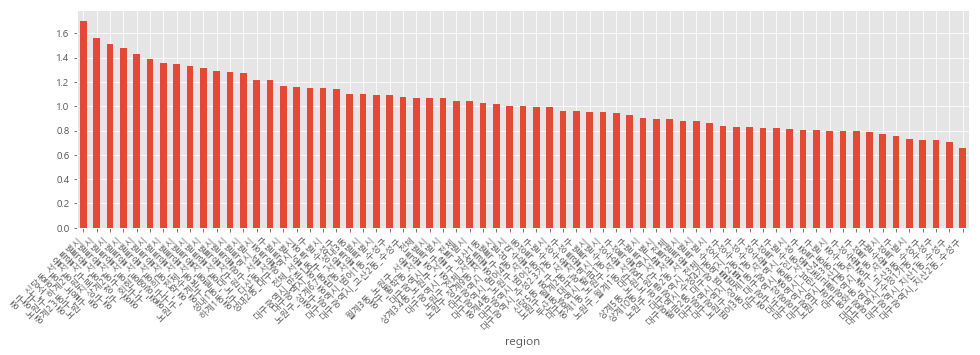

In [68]:
by_dong.mean().sort_values(ascending=False).plot(kind='bar', figsize=(16,4))
plt.xticks(rotation=45, fontsize=9, ha='right')

In [70]:
# by_dong[['PVN', 'BOR','mean_sales']].groupby(['PVN', 'BOR']).describe().drop([('대구광역시',  '전체'), ('서울특별시',  '전체'),(   '전체',  '전체')]).iloc[:,1:2].plot(kind='bar')

### 카테고리별+일자별 매출비중

* 단순매출비중 수치 비교
* 요일별 비교
* 

In [63]:
by_category.head()

,PVN,BOR,ADMD,ANTC_ITEM_LCLS_CD,ANTC_ITEM_LCLS_NM,20190201,20190202,20190203,20190204,20190205,...,20200522,20200523,20200524,20200525,20200526,20200527,20200528,20200529,20200530,20200531
0,서울특별시,중구,소공동,10,식사,0.287643,0.304000,0.275632,0.355523,0.317881,...,0.268470,0.243105,0.327853,0.299879,0.247657,0.265204,0.251100,0.239728,0.230298,0.324881
1,서울특별시,중구,소공동,20,간식,0.185728,0.227291,0.225132,0.238465,0.269207,...,0.195261,0.229224,0.181475,0.173981,0.177090,0.200248,0.195551,0.225265,0.213128,0.191642
2,서울특별시,중구,소공동,30,마실거리,0.383557,0.344574,0.271592,0.308400,0.318957,...,0.394646,0.401531,0.354308,0.411805,0.378491,0.429040,0.421532,0.430289,0.430194,0.374880
3,서울특별시,중구,소공동,40,홈&리빙,0.041739,0.028022,0.017387,0.015014,0.015643,...,0.035964,0.027361,0.027054,0.037556,0.046373,0.025700,0.043245,0.026604,0.042435,0.019790
4,서울특별시,중구,소공동,50,헬스&뷰티,0.081483,0.084229,0.187566,0.057285,0.061882,...,0.086849,0.077277,0.096562,0.064942,0.140060,0.068092,0.075478,0.061774,0.069820,0.070321


* 카테고리별 매출비중

In [71]:
import missingno as msno

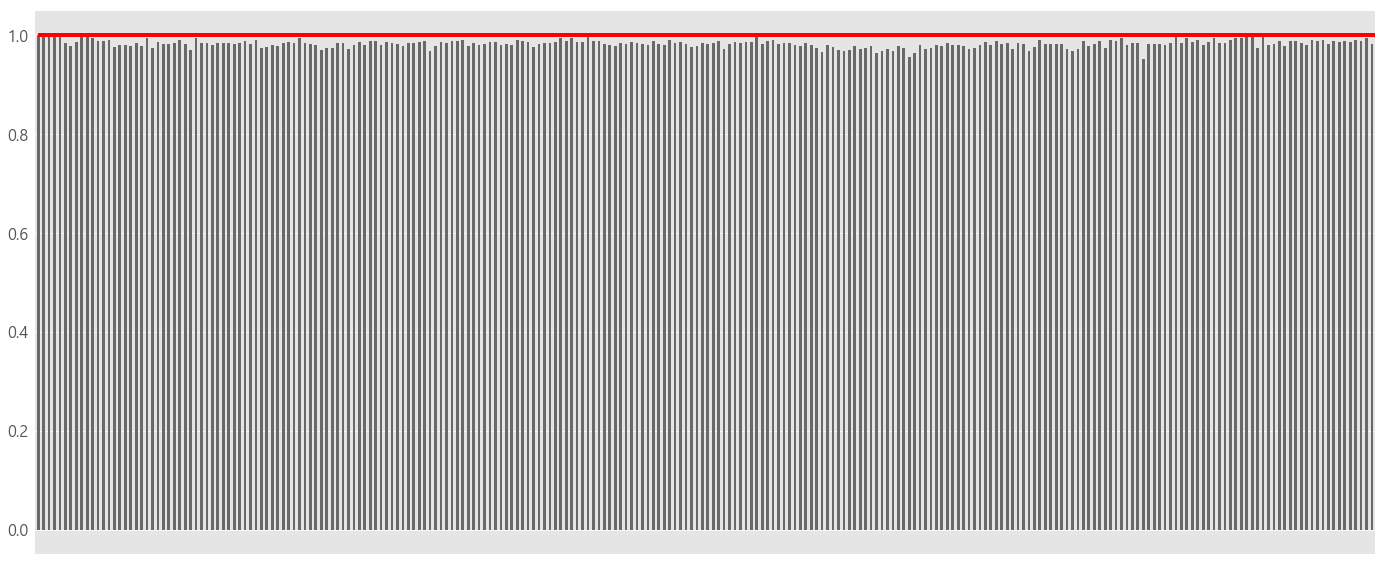

In [72]:
msno.bar(by_category)
plt.hlines(1, 0,246, color='red', linewidth=4)

거의 모든 날짜에 결측값이 존재

In [73]:
by_category.fillna(0).groupby('ADMD').sum().iloc[:,2:].sum(axis=1)

ADMD
고산1동       240.0
고산2동       240.0
고산3동       240.0
공릉1동       240.0
공릉2동       240.0
광희동        240.0
남산1동       240.0
남산4동       240.0
다산동        240.0
동인동        240.0
동화동        240.0
두산동        240.0
만촌1동       240.0
만촌3동       240.0
명동         240.0
범물1동       240.0
범물2동       240.0
범어1동       240.0
범어2동       240.0
범어3동       240.0
범어4동       240.0
삼덕동        240.0
상계10동      240.0
상계1동       240.0
상계2동       240.0
상계3.4동     240.0
상계5동       240.0
상계6.7동     240.0
상계9동       240.0
성내1동       240.0
성내2동       240.0
성내3동       240.0
소공동        240.0
수성1가동      240.0
수성2.3가동    240.0
수성4가동      240.0
신당5동       240.0
신당동        240.0
약수동        240.0
월계1동       240.0
월계2동       240.0
월계3동       240.0
을지로동       240.0
장충동        240.0
중계1동       240.0
중계2.3동     240.0
중계4동       240.0
중계본동       240.0
중동         240.0
중림동        240.0
지산1동       240.0
지산2동       240.0
청구동        240.0
필동         240.0
하계1동       240.0
하계2동       240.0
황금1동       240.0
황금2동       240.0
황학동      

결측치를 0으로 채워넣고 일자별 퍼센티지 합을 구한결과 모두 1이므로 NaN값은 해당 날짜에 해당 카테고리의 품목이 하나도 팔리지 않은 경우로 볼 수 있음. => 결측값 0으로 대체

In [74]:
by_category.fillna(0, inplace=True)

In [76]:
# 중복되는 구명이 있어 지역코드로 변환
by_category['BOR'] = by_category['BOR'].apply(lambda x : convert_name_to_code_dict.get('구코드').get(x))

#### 행정동+카테고리 

In [77]:
from random import choice

In [78]:
# 특정 행정동 예시
random_dong = choice(by_category.ADMD)

In [79]:
tmp_cat = by_category.loc[by_category.ADMD == random_dong]

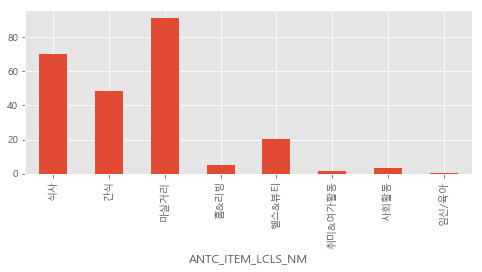

In [80]:
tmp_cat.iloc[:,4:].set_index('ANTC_ITEM_LCLS_NM').T.sum().plot(kind='bar',figsize=(8,3))

Text(0.5, 1.0, '범어1동 일별 카테고리 판매 비중')

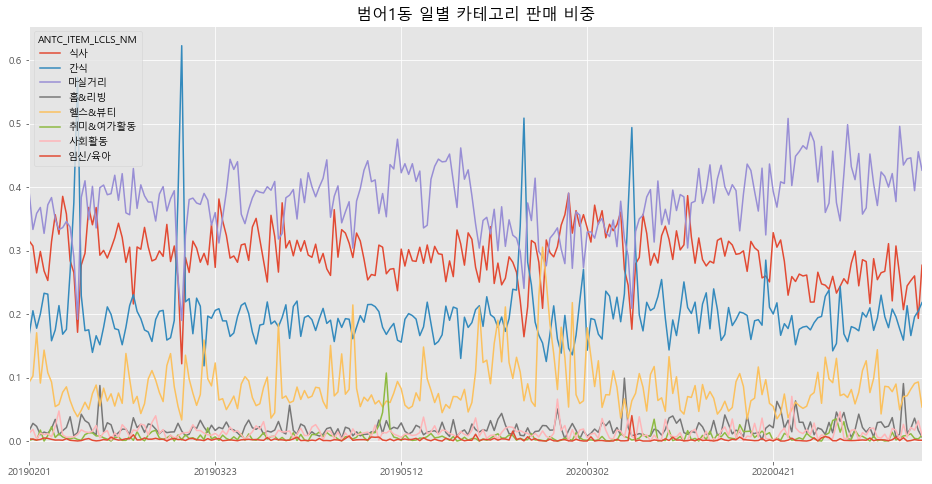

In [81]:
tmp_cat.iloc[:,4:].set_index('ANTC_ITEM_LCLS_NM').T.plot(figsize = (16,8))
plt.title(f'{random_dong} 일별 카테고리 판매 비중', fontsize=16)

In [82]:
by_category.set_index(['ADMD','ANTC_ITEM_LCLS_NM']).drop(['PVN','BOR','ANTC_ITEM_LCLS_CD'], axis=1).mean(axis=1).reset_index(name = 'mean_rate')

,ADMD,ANTC_ITEM_LCLS_NM,mean_rate
0,소공동,식사,0.271417
1,소공동,간식,0.215269
2,소공동,마실거리,0.378010
3,소공동,홈&리빙,0.030737
4,소공동,헬스&뷰티,0.085657
...,...,...,...
475,고산3동,홈&리빙,0.014104
476,고산3동,헬스&뷰티,0.050157
477,고산3동,취미&여가활동,0.005324
478,고산3동,사회활동,0.008298


In [83]:
# (행정동+카테고리별) 평균 매출비중 
tmp_pivot = by_category.set_index(['ADMD','ANTC_ITEM_LCLS_NM']).drop(['PVN','BOR','ANTC_ITEM_LCLS_CD'], axis=1).\
            mean(axis=1).\
            reset_index(name = 'mean_rate').\
            pivot('ADMD','ANTC_ITEM_LCLS_NM','mean_rate')

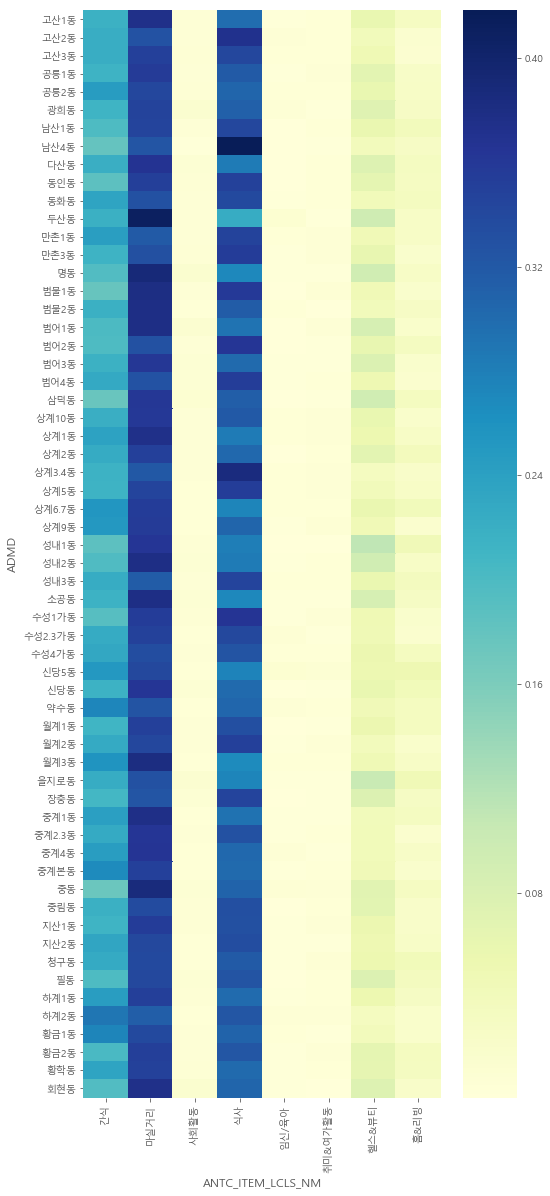

In [84]:
plt.figure(figsize=(8,20))
sns.heatmap(
    by_category.set_index(['ADMD','ANTC_ITEM_LCLS_NM']).drop(['PVN','BOR','ANTC_ITEM_LCLS_CD'], axis=1).\
            mean(axis=1).\
            reset_index(name = 'mean_rate').\
            pivot('ADMD','ANTC_ITEM_LCLS_NM','mean_rate'), cmap='YlGnBu'
)

In [85]:
from sklearn.cluster import KMeans

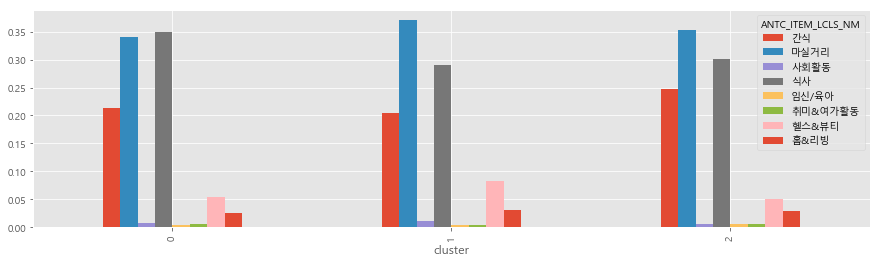

In [86]:
km_clst = KMeans(n_clusters=3)
tmp_pivot['cluster'] = km_clst.fit_predict(tmp_pivot)

tmp_pivot.groupby('cluster').mean().plot(kind='bar', figsize=(15,4))

In [87]:
tmp_pivot.groupby('cluster').mean()

ANTC_ITEM_LCLS_NM,간식,마실거리,사회활동,식사,임신/육아,취미&여가활동,헬스&뷰티,홈&리빙
cluster,,,,,,,,
0,0.213440,0.340323,0.007726,0.348875,0.004163,0.005909,0.053458,0.026106
1,0.205210,0.370366,0.011267,0.290290,0.004423,0.004902,0.082709,0.030833
2,0.247895,0.353044,0.006611,0.300275,0.005575,0.006073,0.050501,0.030025


지역에 따른 편의점 소비 카테고리의 차이는 별로 느껴지지 않음 (추후 클러스터 갯수를 변화시키며 통계적으로 유의미한 차이가 있는지 알아볼 필요는 있을듯) 

In [89]:
for col in tmp_pivot.columns[:-1]:
    tmp_anova = tmp_pivot.loc[:,[col]+['cluster']]
    groups = list(tmp_anova.groupby('cluster')[col].apply(lambda x : list(x)))
    
    F_statistic, pVal=scipy.stats.f_oneway(*groups)

    if pVal < 0.01:
        print(f'ㅁ{col} : Cluster별 유의미한 차이가 존재')
        
        tmp = copy.deepcopy(tmp_anova)
        tmp.columns = ['variable', 'cluster']
        model = ols('variable ~ C(cluster)', tmp).fit()
        print(anova_lm(model))
        print('')
    else:
        print(f'ㅁ{col} : Cluster별 차이없음\n')

ㅁ간식 : Cluster별 유의미한 차이가 존재
              df    sum_sq   mean_sq          F        PR(>F)
C(cluster)   2.0  0.018475  0.009238  29.918233  1.307521e-09
Residual    57.0  0.017600  0.000309        NaN           NaN

ㅁ마실거리 : Cluster별 유의미한 차이가 존재
              df    sum_sq   mean_sq          F    PR(>F)
C(cluster)   2.0  0.008960  0.004480  15.204535  0.000005
Residual    57.0  0.016795  0.000295        NaN       NaN

ㅁ사회활동 : Cluster별 유의미한 차이가 존재
              df    sum_sq   mean_sq          F        PR(>F)
C(cluster)   2.0  0.000201  0.000100  29.211691  1.849525e-09
Residual    57.0  0.000196  0.000003        NaN           NaN

ㅁ식사 : Cluster별 유의미한 차이가 존재
              df    sum_sq   mean_sq          F        PR(>F)
C(cluster)   2.0  0.042698  0.021349  52.449984  1.199225e-13
Residual    57.0  0.023201  0.000407        NaN           NaN

ㅁ임신/육아 : Cluster별 차이없음

ㅁ취미&여가활동 : Cluster별 차이없음

ㅁ헬스&뷰티 : Cluster별 유의미한 차이가 존재
              df    sum_sq   mean_sq          F        PR(>F)
C(cluster)

#### 요일 + 카테고리 

##### 특정 행정동 

In [90]:
random_dong = choice(by_category.ADMD)

In [91]:
tmp_cat = by_category.loc[by_category.ADMD == random_dong]

In [342]:
#요일을 고려하기 위해 데이터형태변환

In [92]:
tmp_cat = tmp_cat.drop(['PVN','BOR','ADMD','ANTC_ITEM_LCLS_CD'], axis=1).\
                  set_index('ANTC_ITEM_LCLS_NM')

In [93]:
tmp_cat.columns = pd.to_datetime(tmp_cat.columns) #datetime type으로 변환

In [94]:
tmp_cat = tmp_cat.T

In [95]:
tmp_cat['year'] = pd.Series(tmp_cat.index).dt.year.values
tmp_cat['month'] = pd.Series(tmp_cat.index).dt.month.values
tmp_cat['dayofweek'] = pd.Series(tmp_cat.index).dt.dayofweek.values

In [96]:
tmp_cat.groupby(['dayofweek']).mean()

ANTC_ITEM_LCLS_NM,식사,간식,마실거리,홈&리빙,헬스&뷰티,취미&여가활동,사회활동,임신/육아,year,month
dayofweek,,,,,,,,,,
0,0.359584,0.207643,0.338834,0.020951,0.051538,0.004345,0.007558,0.009548,2019.500000,3.500000
1,0.340750,0.225095,0.346618,0.018026,0.051953,0.004133,0.005948,0.007478,2019.500000,3.500000
2,0.339401,0.227701,0.353961,0.015278,0.046215,0.003256,0.005434,0.008755,2019.500000,3.558824
3,0.336312,0.230320,0.344606,0.017739,0.054351,0.003054,0.006225,0.007392,2019.500000,3.558824
4,0.349089,0.228996,0.342006,0.016547,0.045111,0.003747,0.005456,0.009047,2019.485714,3.571429
5,0.315555,0.238218,0.367075,0.013271,0.046741,0.003681,0.006681,0.008778,2019.514286,3.485714
6,0.348953,0.218945,0.353722,0.017221,0.044790,0.003579,0.006347,0.006444,2019.514286,3.514286


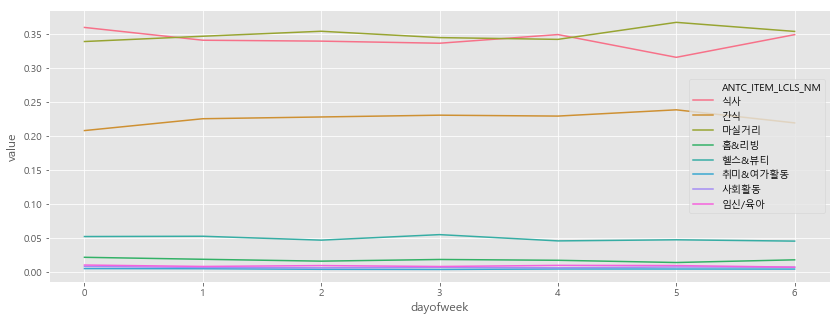

In [97]:
plt.figure(figsize=(14,5))
sns.lineplot(
    data = tmp_cat.groupby(['dayofweek']).mean().\
            reset_index().\
            drop(['year','month'], axis=1).\
            melt(id_vars=['dayofweek']),
    x = 'dayofweek',
    y = 'value',
    hue = 'ANTC_ITEM_LCLS_NM'
)

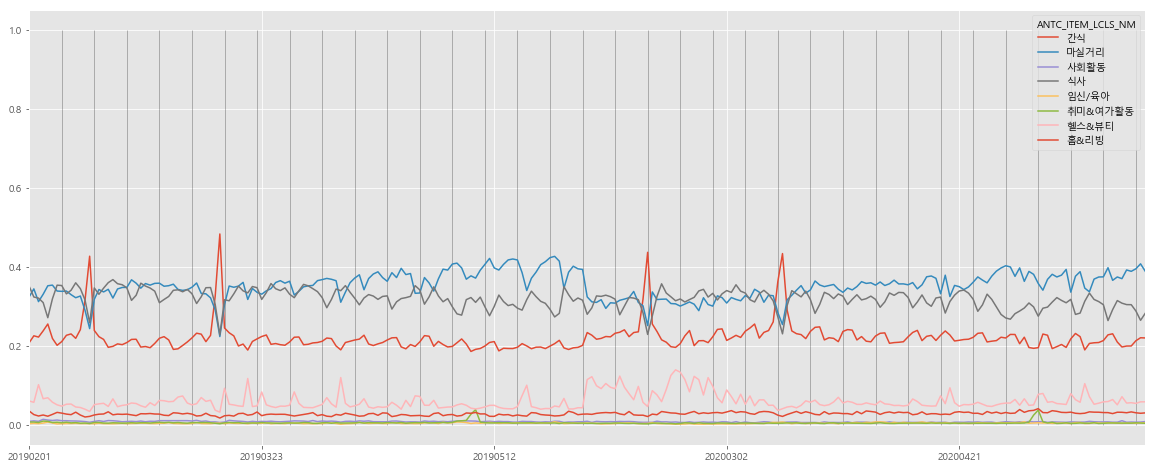

In [98]:
by_category.groupby('ANTC_ITEM_LCLS_NM').mean().iloc[:,2:].T.plot(figsize=(20,8))
plt.vlines(range(244)[::7],0,1, linewidth=0.5, alpha=0.5)

각 품목별로 변동이 주기적으로 존재하는것 같음

In [100]:
for col in tmp_cat.columns[:-4]:
    tmp_anova = tmp_cat.loc[:,[col]+['dayofweek']]
    groups = list(tmp_anova.groupby('dayofweek')[col].apply(lambda x : list(x)))
    
    F_statistic, pVal=scipy.stats.f_oneway(*groups)

    if pVal < 0.01:
        print(f'ㅁ{col} : 요일별 유의미한 차이가 존재')
        
        tmp = copy.deepcopy(tmp_anova)
        tmp.columns = ['variable', 'dayofweek']
        model = ols('variable ~ C(dayofweek)', tmp).fit()
        print(anova_lm(model))
        print('')
    else:
        print(f'ㅁ{col} : 요일별 차이없음\n')

ㅁ식사 : 요일별 유의미한 차이가 존재
                 df    sum_sq   mean_sq         F    PR(>F)
C(dayofweek)    6.0  0.039715  0.006619  4.420766  0.000296
Residual      234.0  0.350365  0.001497       NaN       NaN

ㅁ간식 : 요일별 차이없음

ㅁ마실거리 : 요일별 차이없음

ㅁ홈&리빙 : 요일별 차이없음

ㅁ헬스&뷰티 : 요일별 차이없음

ㅁ취미&여가활동 : 요일별 차이없음

ㅁ사회활동 : 요일별 차이없음



In [101]:
### +주말,주중으로 나눠서 다시 진행
tmp_cat['daytype'] = np.where(tmp_cat.dayofweek <= 4, '주중','주말')

In [102]:
for col in tmp_cat.columns[:-4]:
    tmp_anova = tmp_cat.loc[:,[col]+['daytype']]
    groups = list(tmp_anova.groupby('daytype')[col].apply(lambda x : list(x)))
    F_statistic, pVal=scipy.stats.f_oneway(*groups)
    if pVal < 0.01:
        print(f'ㅁ{col} : 주중/주말 유의미한 차이가 존재')
    else:
        print(f'ㅁ{col} : 주중/주말 차이없음')

ㅁ식사 : 주중/주말 차이없음
ㅁ간식 : 주중/주말 차이없음
ㅁ마실거리 : 주중/주말 차이없음
ㅁ홈&리빙 : 주중/주말 차이없음
ㅁ헬스&뷰티 : 주중/주말 차이없음
ㅁ취미&여가활동 : 주중/주말 차이없음
ㅁ사회활동 : 주중/주말 차이없음
ㅁ임신/육아 : 주중/주말 차이없음


In [103]:
by_category.groupby('ANTC_ITEM_LCLS_NM').mean().iloc[:,2:].T.mean().sort_values(ascending=False)

ANTC_ITEM_LCLS_NM
마실거리       0.352151
식사         0.318673
간식         0.221582
헬스&뷰티      0.060371
홈&리빙       0.028542
사회활동       0.008336
취미&여가활동    0.005690
임신/육아      0.004656
dtype: float64

In [104]:
by_category.groupby('ANTC_ITEM_LCLS_NM').mean().loc[:,['20190213','20190214','20190314','20190508','20200214','20200314','20200508']]

,20190213,20190214,20190314,20190508,20200214,20200314,20200508
ANTC_ITEM_LCLS_NM,,,,,,,
간식,0.315257,0.427031,0.483280,0.191448,0.436882,0.433705,0.195697
마실거리,0.290446,0.243884,0.223771,0.371634,0.251556,0.254116,0.358079
사회활동,0.008712,0.006960,0.006398,0.009964,0.006942,0.006251,0.008407
식사,0.316566,0.258614,0.228133,0.310302,0.229181,0.230686,0.275192
임신/육아,0.003696,0.003426,0.004985,0.005329,0.004149,0.007602,0.005750
취미&여가활동,0.005023,0.003831,0.003215,0.038900,0.003053,0.004692,0.037697
헬스&뷰티,0.039966,0.034397,0.032540,0.040730,0.046735,0.041148,0.077659
홈&리빙,0.020335,0.021858,0.017678,0.031692,0.021502,0.021800,0.041518


In [105]:
pd.options.display.max_columns = 60

In [106]:
%%html
<style>
table {float:left}
</style>

|분석용상품대분류명 | 상품 예시 |
|---|-------------------------------------|
|식사 | F/F, 김치, 통조림, 즉석식품 |
|간식	| 견과, 스낵, 껌/캔디/젤리, 과일 |
|마실거리 |	음료, 유제품 |
|홈&리빙 |	라이터, 건전지, 일회용품, 방향제 |
|헬스&뷰티 | 마스크, 샴푸, 린스, 칫솔 |
|취미&여가활동 | 완구, 대형가전, 애완동물, 레져 |
|사회활동 | 문구, 소형가전(이어폰 등) |
|임신/육아 | 유아, 인형 |

* F/F : Fresh Food

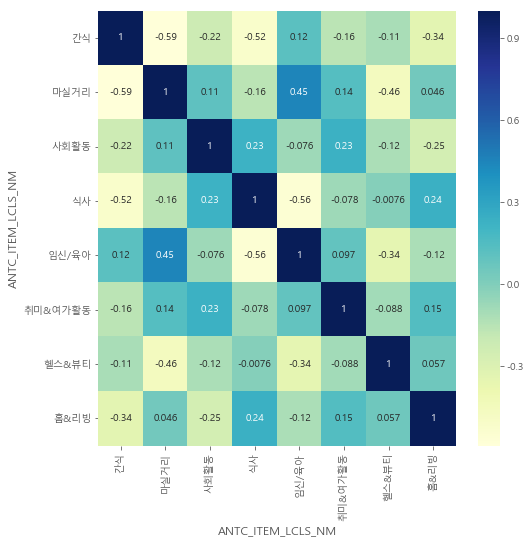

In [107]:
plt.figure(figsize=(8,8))
sns.heatmap(by_category.groupby('ANTC_ITEM_LCLS_NM').mean().drop(['BOR','ANTC_ITEM_LCLS_CD'], axis=1).T.corr(), cmap='YlGnBu', annot=True)

In [108]:
# by_category.groupby('ANTC_ITEM_LCLS_NM').mean().drop(['BOR','ANTC_ITEM_LCLS_CD'], axis=1).T.corr()

* 간식&식사 : 음의상관관계 OK
* 간식&마실거리 : 음의상관관계?
* 마실거리&임신/육아 : 양의상관관계??? 임신/육아 무슨 품목? (GS25편의점에서 분유는 팔지 않는듯. 우유와 분유를 생각했는데 아닌듯)
* 식사&홈리빙 : 일회용젓가락 혹은 일회용컵 등과 함께?
* 식사&사회활동 : ???

행정동별로 차이가 존재함

##### 행정동 전체